# Lake Water Temperature from Satellite Data

This dataset provides mid-morning daily lake surface water temperature (LSWT) values derived from satellite data, along with associated uncertainty and quality levels. The data, retrieved from ATSR and AVHRR sensors, have been bias-adjusted for consistency and may contain gaps due to missing observations. LSWT is an essential climate variable critical for understanding lake ecology, hydrological processes, and large-scale climate interactions, with data development supported by the UK NERC GloboLakes project and future enhancements from the ESA Climate Change Initiative.

**Quick Navigation:**

* [Download and Extract the Dataset](#download-and-extract-the-dataset)
* [Merge NetCDF4 Files into a Single NetCDF4 File](#merge-netcdf4-files-into-a-single-netcdf4-file)
* [Investigate the Metadata of the NetCDF4 file](#investigate-the-metadata-of-the-netcdf4-file)
* [Export the time series in CSV format](#export-the-time-series-in-csv-format)
* [Analysis and Visualization Options](#analysis-and-visualization-options)
* [Export the merged NetCDF4 file to GeoTIFF](#export-the-merged-netcdf4-file-to-geotiff)
* [Additional Visualization using a Calendar Plot](#additional-visualization-using-a-calendar-plot)

**Information on Dataset:**
* Source: <a href="https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview" target="_blank">Satellite Lake Water Temperature</a>
* Author: T. Tewes (City of Konstanz)
* Notebook Version: 1.4 (Updated: January 20, 2025)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Specify Directories Here ---- '''
download_folder = r".\data\satellite-lake-water-temperature\download"
working_folder = r".\data\satellite-lake-water-temperature\working"
geotiff_folder = r".\data\satellite-lake-water-temperature\geotiff"
csv_folder = r".\data\satellite-lake-water-temperature\csv"
output_folder = r".\data\satellite-lake-water-temperature\output"
''' ----- End of Declaration ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract the Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    # API key for authentication
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Creation of the CDS API client
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Define the "request" and Download the Dataset

Define additional request fields to ensure the request stays within the file size limit. When working with geospatial data or APIs that return map or satellite imagery, limiting the geographical area of interest can prevent overly large requests that exceed file size or processing limits. Bounding boxes are used to define
the geographic area for such requests.

The coordinates below were obtained using the <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> tool.

*BBox Extractor is a web-based tool that helps users interactively select and generate bounding box coordinates in WGS84 format (latitude/longitude). This is especially useful when working with APIs or datasets that require a geographic area input.*

In [3]:
# Define the bounding box coordinates (WGS84 format) for the Lake Constance region.
# The coordinates are in the format: [North, West, South, East]
bbox_wgs84_constance = [48.0, 8.7, 47.3, 9.9]

In [4]:
# Specify the year of interest for the data request.
# The corresponding data version depends on the year.
year = 2007

# Determine the data version based on the year:
# Version "4_5_1" is used for years up to 2020, and "4_5_2" is used for later years.
if 1900 <= year <= 2100:  # Validate year range for robustness.
    version = "4_5_1" if year <= 2020 else "4_5_2"
else:
    raise ValueError(f"Invalid year: {year}. Please provide a year between 1900 and 2100.")

In [5]:
# Definition of the dataset and the request parameters
dataset = "satellite-lake-water-temperature"
request = {
    "variable": "all",
    "year": [f"{year}"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "version": version,
    "area": bbox_wgs84_constance
}

In [6]:
# Execute it to download the dataset:
def main_retrieve():
    dataset_filename = f"{dataset}_{request['year'][0]}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Call the CDS client only if the dataset has not been downloaded before
        client = main()
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")
        
if __name__ == "__main__":
    main_retrieve()

Dataset already downloaded.


### 2.3 Extract the ZIP files in folder(s)

In [7]:
import zipfile

# Construct the filename and filepath for the ZIP file based on selected year
dataset_filename = f"{dataset}_{year}.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)

# Create a folder to extract the ZIP file based on the selected year
extract_folder = os.path.join(working_folder, str(year))

# Extract the ZIP file only if the folder is empty
try:
    os.makedirs(extract_folder, exist_ok=True)
    
    if not os.listdir(extract_folder):
        # Attempt to open and extract the ZIP file
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted files to: .\data\satellite-lake-water-temperature\working\2007


## 3. Merge NetCDF4 Files into a Single NetCDF4 File

Many **yearly datasets** are provided as daily NetCDF4 files, where each file represents one day of the year *(365 files for regular years, 366 files for leap years)*. Managing these numerous files can be cumbersome, especially during data access or visualization.

To simplify workflows and improve data handling efficiency, all daily datasets for a given year are merged into a **single yearly NetCDF4 file**. This consolidation streamlines data processing in later stages of analysis, such as visualization or statistical evaluation.

> Important: Daily datasets may have sparse or missing data.  As a result, the merged NetCDF4, merged GeoTIFF, or individual GeoTIFF files may contain empty time instances. 

In [8]:
import xarray as xr

# Define file path for the merged NetCDF file (1 file per year)
nc_filepath_merged = os.path.join(output_folder,f"{dataset}_{year}.nc")

# Check if the merged file already exists
if not os.path.isfile(nc_filepath_merged):
    # List all NetCDF files in the extract folder
    filename_list = os.listdir(extract_folder)

    if not filename_list:
        print(f"No NetCDF files found in {extract_folder}.")
    else:
        try:
            # Open and concatenate all NetCDF files along the 'time' dimension
            datasets = [xr.open_dataset(os.path.join(extract_folder, f)) for f in filename_list]
            merged_dataset = xr.concat(datasets, dim='time')
            
            # Save the merged dataset to the new NetCDF file
            merged_dataset.to_netcdf(nc_filepath_merged)
            print(f"New NetCDF4 file created at {nc_filepath_merged} for year {year}")
        
        except Exception as e:
            print(f"Error during file processing: {e}")
else:
    print(f"Merged NetCDF file already exists for {year}. Skipping merge.")

New NetCDF4 file created at .\data\satellite-lake-water-temperature\output\satellite-lake-water-temperature_2007.nc for year 2007


## 4. Investigate the Metadata of the NetCDF4 file

In [9]:
import netCDF4 as nc

# Define the file path for the merged netCDF dataset
nc_filename = f"satellite-lake-water-temperature_{year}.nc"
nc_filepath = os.path.join(output_folder, nc_filename)

# Open the merged NetCDF file in read mode
nc_dataset = nc.Dataset(nc_filepath_merged, mode="r")

# List all variables in the dataset
variables_list = nc_dataset.variables.keys()
print(f"Available variables: {list(variables_list)}")

Available variables: ['lake_surface_water_temperature', 'lswt_uncertainty', 'lswt_quality_level', 'lswt_obs_instr', 'lswt_flag_bias_correction', 'lakeid_CCI', 'lakeid_GloboLakes', 'lat', 'lon', 'time']


In [10]:
import pandas as pd

# Define variable name from available variables and read variable data
variable_name = 'lake_surface_water_temperature'
variable_data = nc_dataset[variable_name]

# Create a summary of the primary variables
summary = {
    "Variable Name": variable_name,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{variable_data.dimensions}",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display the summary of the data set as a DataFrame for better visualisation
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

# Display the summary DataFrame
nc_summary

,Description,Remarks
0,Variable Name,lake_surface_water_temperature
1,Data Type,int16
2,Shape,"(365, 14, 24)"
3,Variable Info,"('time', 'lat', 'lon')"
4,Units,kelvin
5,Long Name,lake surface skin water temperature


In [11]:
# Print a summary of all the variables of the dataset
rows = []
for variable in variables_list:
    try:
        var_obj = nc_dataset.variables[variable]
        unit = getattr(var_obj, 'units', 'N/A')
        shape = var_obj.shape
        rows.append({
            "nc_variables": variable,
            "unit": unit,
            "shape": shape
        })
    except Exception as e:
        print(f"Error processing variable {variable}: {e}")

# Create a DataFrame
df = pd.DataFrame(rows)
df

,nc_variables,unit,shape
0,lake_surface_water_temperature,kelvin,"(365, 14, 24)"
1,lswt_uncertainty,kelvin,"(365, 14, 24)"
2,lswt_quality_level,N/A,"(365, 14, 24)"
3,lswt_obs_instr,N/A,"(365, 14, 24)"
4,lswt_flag_bias_correction,N/A,"(365, 14, 24)"
5,lakeid_CCI,1,"(365, 14, 24)"
6,lakeid_GloboLakes,1,"(365, 14, 24)"
7,lat,degrees_north,"(14,)"
8,lon,degrees_east,"(24,)"
9,time,seconds since 1970-01-01,"(365,)"


## 5. Export the time series in CSV Format

### 5.1 Define a Function to Compute Daily Average

In [12]:
import netCDF4 as nc
import pandas as pd
import numpy as np

# Function for converting NetCDF data into a Pandas DataFrame
def netcdf_to_dataframe(nc_file):
    """
    Converts a NetCDF file containing lake surface water temperature (LSWT) data
    into a Pandas DataFrame with computed statistics.

    Parameters:
    nc_file (str): Path to the NetCDF file.

    Returns:
    pd.DataFrame: A DataFrame containing time, mean temperature, standard deviation, 
                  uncertainty, mean quality level, and non-zero count of pixels.
    """
    # Open the NetCDF dataset in read mode
    with nc.Dataset(nc_file, "r") as nc_dataset:
        # Extract and decode the time variable using the calendar and units
        time_var = nc_dataset.variables["time"]
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        datetime_cftime = [t.strftime("%Y-%m-%d %H:%M:%S") for t in cftime]

        # Extract temperature data and its associated units
        temperature_data = nc_dataset.variables["lake_surface_water_temperature"][:]
        temperature_data_units = nc_dataset.variables["lake_surface_water_temperature"].units

        # Calculate the mean temperature and standard deviation for each time step (averaged over spatial dimensions)
        temperature_mean_list = np.nanmean(temperature_data, axis=(1, 2))
        temperature_std_list = np.nanstd(temperature_data, axis=(1, 2))
        
        # Count the number of valid (non-NaN) pixels for each time step
        nonzero_count_list = np.count_nonzero(~np.isnan(temperature_data), axis=(1,2))

        # Extract uncertainty data and its units
        lswt_uncertainty = nc_dataset.variables["lswt_uncertainty"][:]
        lswt_uncertainty_units = nc_dataset.variables["lswt_uncertainty"].units

        # Propagate uncertainty of mean temperature using root mean square of uncertainty
        lswt_uncertainty_squared = np.nanmean(lswt_uncertainty**2, axis=(1, 2))
        lswt_mean_uncertainty = np.sqrt(lswt_uncertainty_squared)
        
        # Extract and compute mean quality level for each time step
        lswt_quality_level = nc_dataset.variables["lswt_quality_level"][:]
        lswt_quality_level_mean_list = np.nanmean(lswt_quality_level, axis=(1, 2))

        # Create a DataFrame with computed statistics
        df = pd.DataFrame(
            {
                "Time": datetime_cftime,
                f"Mean Temperature ({temperature_data_units[0].capitalize()})": temperature_mean_list,
                "Std Dev": temperature_std_list,
                f"Uncertainty ({lswt_uncertainty_units[0].capitalize()})": lswt_mean_uncertainty,
                f"Mean Quality Level": lswt_quality_level_mean_list,
                "Non-Zero Count":nonzero_count_list,
            }
        )
        return df

### 5.2 Create DataFrame for yearly data and Export as CSV

In [13]:
import pandas as pd

# Define csv filename and filepath for the output
csv_filename = f"{dataset}_daily-mean_{year}.csv"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Export the DataFrame as CSV if it does not already exist
if not os.path.isfile(csv_filepath):
    dataframe = netcdf_to_dataframe(nc_filepath_merged)
    filtered_dataframe = dataframe.dropna().reset_index(drop=True)

    filtered_dataframe.to_csv(csv_filepath, sep=",", encoding='utf8', index=False)
    print(f"Filtered data exported successfully to {csv_filepath}")
else:
    print(f"File already exists at {csv_filepath}.\nSkipping export.")
    print("Reading existing CSV file...")
    filtered_dataframe = pd.read_csv(csv_filepath)

# Modify the Pandas display options
pd.options.display.float_format = '{:,.2f}'.format

# Display the DataFrame
filtered_dataframe.head()

Filtered data exported successfully to .\data\satellite-lake-water-temperature\csv\satellite-lake-water-temperature_daily-mean_2007.csv


,Time,Mean Temperature (K),Std Dev,Uncertainty (K),Mean Quality Level,Non-Zero Count
0,2007-01-02 12:00:00,278.46,0.11,0.43,4.86,7.00
1,2007-01-05 12:00:00,275.98,0.58,0.29,3.60,5.00
2,2007-01-06 12:00:00,278.64,0.00,0.34,4.00,1.00
3,2007-01-11 12:00:00,277.96,1.43,0.18,3.14,7.00
4,2007-01-14 12:00:00,278.68,0.76,0.19,4.30,20.00


## 6. Analysis and Visualization Options

### 6.1 Visualization of Daily Average with Line Graph

> Note: Due to limited daily/monthly data for 2023 dataset, **Plots** do not work properly

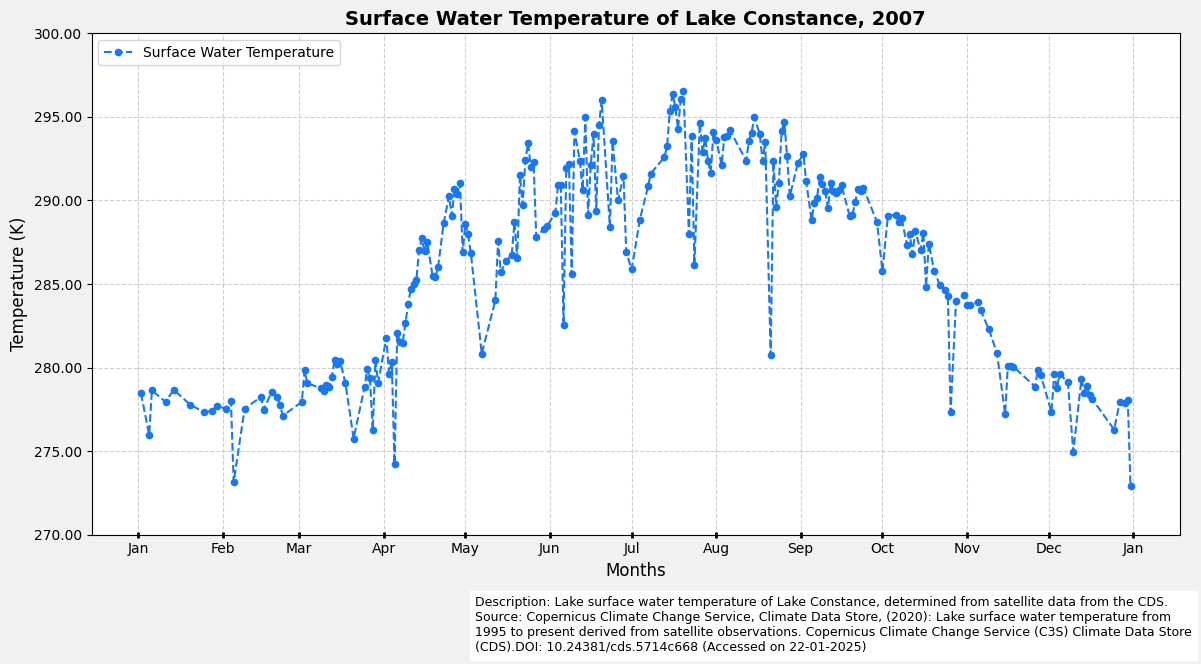

In [14]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator 
import matplotlib.ticker as ticker
import math

# Prepare the DataFrame for plotting
filtered_df = filtered_dataframe.copy()

# Convert 'Time' to datetime format, and extract and format the 'Date' column
filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])
filtered_df['Date'] = filtered_df['Time'].dt.date

# Determine the range for the y-axis, rounding to the nearest 10
vmax = math.ceil(filtered_df['Mean Temperature (K)'].max() / 10) * 10
vmin = math.floor(filtered_df['Mean Temperature (K)'].min() / 10) * 10

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the mean temperature data
ax.plot(filtered_df['Date'],
        filtered_df['Mean Temperature (K)'],
        marker='o',
        markersize=4.5,
        linestyle='--',
        color='#1877F2',
        label="Surface Water Temperature",
        )

# Format the x-axis for better readability
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limits
ax.set_ylim(vmin, vmax)

# Set axis labels and chart title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Surface Water Temperature of Lake Constance, {year}', fontsize=14, fontweight='bold')

# Add grid to the plot and format y-axis
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add description and source information
plt.figtext(
    0.4,
    -0.05,
    (
        'Description: Lake surface water temperature of Lake Constance, determined from satellite data from the CDS.\n'
        'Source: Copernicus Climate Change Service, Climate Data Store, (2020): Lake surface water temperature from 1995 '
        'to present derived from satellite observations. Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
        'DOI: 10.24381/cds.5714c668 (Accessed on 22-01-2025)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

ax.legend(loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 6.2 Visualization of Monthly Average with Line Graph

In [15]:
# Prepare the DataFrame for plotting by monthly aggregation and error progagation

# Group by monthly periods using the 'Date' column
filtered_df_monthly = (
    filtered_df.groupby(pd.PeriodIndex(filtered_df["Date"], freq="M"))[[
        "Mean Temperature (K)",
        "Std Dev",
        "Uncertainty (K)",
        "Mean Quality Level"
    ]]
    .agg({
        "Mean Temperature (K)": "mean",
        "Std Dev": lambda x: (x**2).mean()**0.5,
        "Uncertainty (K)": lambda x: (x**2).mean()**0.5,
        "Mean Quality Level": "mean"
    })
    .reset_index()
)

# Convert the PeriodIndex back to timestamps for consistent datetime handling
filtered_df_monthly['Date'] = filtered_df_monthly['Date'].dt.to_timestamp()

# Display DataFrame
filtered_df_monthly.head()

,Date,Mean Temperature (K),Std Dev,Uncertainty (K),Mean Quality Level
0,2007-01-01,277.77,0.63,0.31,4.16
1,2007-02-01,277.36,0.35,0.23,4.14
2,2007-03-01,279.02,1.16,0.28,3.70
3,2007-04-01,285.22,1.27,0.27,3.41
4,2007-05-01,288.30,1.75,0.42,3.28


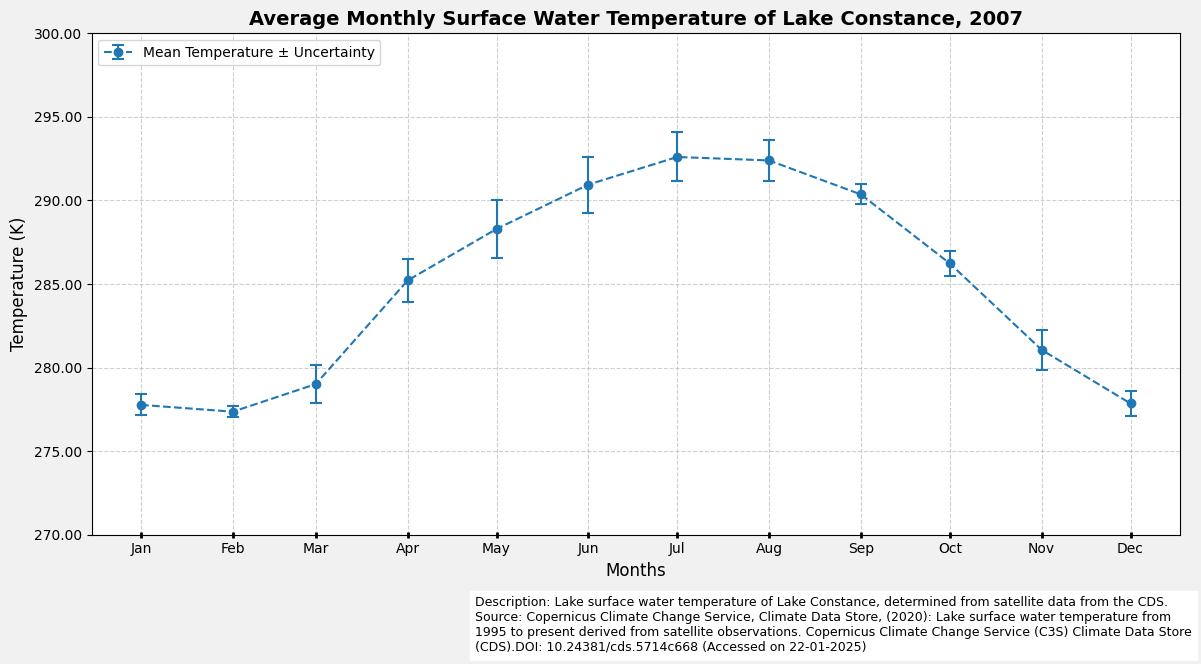

In [16]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the monthly mean temperature data
ax.errorbar(
    filtered_df_monthly['Date'],
    filtered_df_monthly['Mean Temperature (K)'],
    yerr=filtered_df_monthly['Std Dev'],
    fmt='o--',
    label='Mean Temperature ± Uncertainty',
    capsize=4,
    elinewidth=1.5,
    capthick=1.5,
)

# Format the x-axis for better readability
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limits
ax.set_ylim(vmin, vmax)

# Set axis labels and chart title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Average Monthly Surface Water Temperature of Lake Constance, {year}', fontsize=14, fontweight='bold')

# Add grid to the plot and format y-axis
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add description and source information
plt.figtext(
    0.4,
    -0.05,
    (
        'Description: Lake surface water temperature of Lake Constance, determined from satellite data from the CDS.\n'
        'Source: Copernicus Climate Change Service, Climate Data Store, (2020): Lake surface water temperature from 1995 '
        'to present derived from satellite observations. Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
        'DOI: 10.24381/cds.5714c668 (Accessed on 22-01-2025)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

ax.legend(loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 6.3 Visualization of Monthly Average with Bar Graph

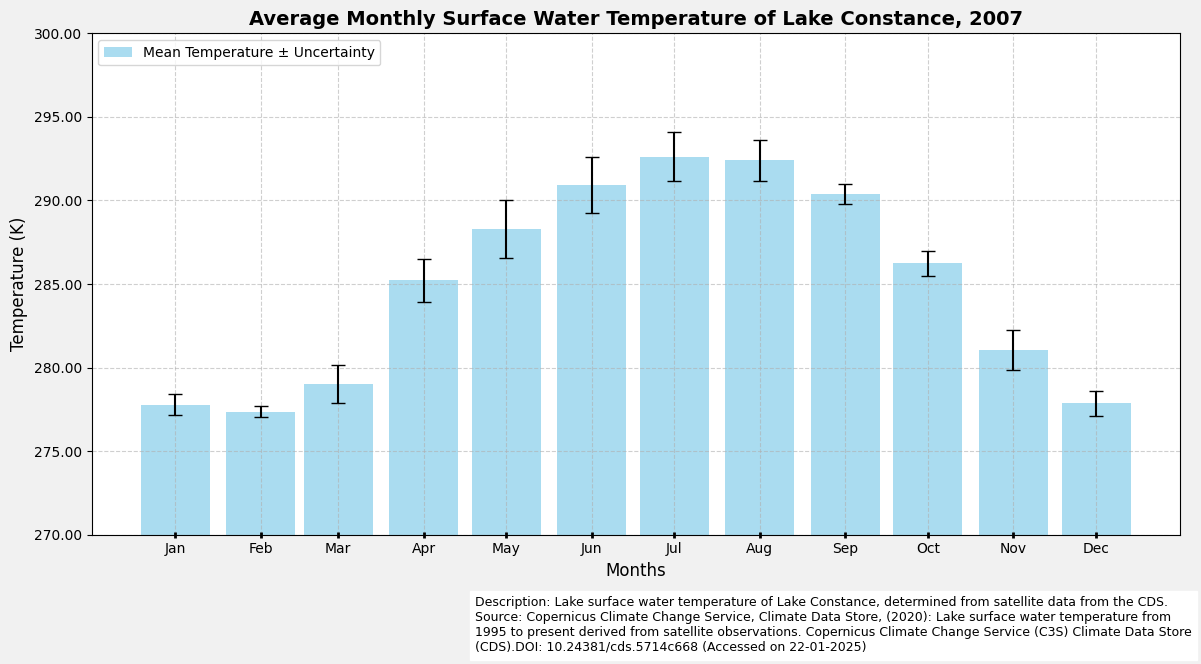

In [17]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the monthly mean temperature data
ax.bar(filtered_df_monthly['Date'],
       filtered_df_monthly['Mean Temperature (K)'],
       yerr=filtered_df_monthly['Std Dev'],
       color='skyblue',
       alpha=0.7,
       width=25,
       label='Mean Temperature ± Uncertainty',
       capsize=5,
       error_kw=dict(ecolor='black', lw=1.5),
       )

# Format the x-axis for better readability
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2) 
ax.tick_params(axis='x', which='minor', length=3, direction='inout') 

# Set y-axis limits
ax.set_ylim(vmin, vmax)

# Set axis labels and chart title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Average Monthly Surface Water Temperature of Lake Constance, {year}', fontsize=14, fontweight='bold')

# Add grid to the plot and format y-axis
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add description and source information
plt.figtext(
    0.4,
    -0.05,
    (
        'Description: Lake surface water temperature of Lake Constance, determined from satellite data from the CDS.\n'
        'Source: Copernicus Climate Change Service, Climate Data Store, (2020): Lake surface water temperature from 1995 '
        'to present derived from satellite observations. Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
        'DOI: 10.24381/cds.5714c668 (Accessed on 22-01-2025)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

ax.legend(loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## 7. Export the merged NetCDF4 file to GeoTIFF

### 7.1 Export All-Year Dataset as Merged GeoTIFF File

In [18]:
import rasterio
from rasterio.transform import from_origin
import netCDF4 as nc
from tqdm.notebook import tqdm

def main_export_geotiff(nc_file):
    # Open the NetCDF file and read the variable
    nc_dataset = nc.Dataset(nc_file, mode='r')
    temperature_data = nc_dataset[variable_name]
    
    # Extract the time variable and convert it to readable date format
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
    # Calculate spatial resolution and define raster transformation
    lat = nc_dataset['lat'][:]
    lon = nc_dataset['lon'][:]
    
    pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
    pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)
    transform = from_origin(lon.min() - pixel_size_lon / 2,
                            lat.min() - pixel_size_lat / 2,
                            pixel_size_lon,
                            -pixel_size_lat
                            )
    
    # Define output file path for the merged GeoTIFF
    output_filename = f"{variable_name}_{year}_merged.tif"
    output_folder = os.path.join(geotiff_folder, "merged_geotiff")
    os.makedirs(output_folder, exist_ok=True)
    output_filepath = os.path.join(output_folder, output_filename)
    
    if not os.path.isfile(output_filepath):
        # Create a GeoTIFF with multiple bands (one per time slice)
        with rasterio.open(
            output_filepath,
            "w",
            driver = "GTiff",
            dtype = str(temperature_data.dtype),
            width = temperature_data.shape[2],
            height = temperature_data.shape[1],
            count = temperature_data.shape[0],
            crs = "EPSG:4326",
            nodata = -9999,
            transform=transform,        
        ) as dst:
            # Write each time slice as a separate band
            for day_index in tqdm(range(temperature_data.shape[0]),
                                  desc=f"Exporting merged GeoTIFF file for {year}"):
                band_data = temperature_data[day_index,:,:]
                dt = cftime[day_index]
                band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                
                # Write the data for the current band and annotate the band
                dst.write(band_data, day_index + 1)
                dst.set_band_description(day_index + 1, band_desc)
    else:
        print(f"'{output_filename}' already exists. Skipping export.")

# Parameters for processing the NetCDF file
nc_filename = f"{dataset}_{year}.nc"
nc_filepath_merged = os.path.join(output_folder, nc_filename)
variable_name = 'lake_surface_water_temperature'

main_export_geotiff(nc_filepath_merged)

Exporting merged GeoTIFF file for 2007:   0%|          | 0/365 [00:00<?, ?it/s]

### 7.2 Export All-Year Dataset as Individual GeoTIFF File

In [19]:
import rasterio
from rasterio.transform import from_origin
import netCDF4 as nc
from tqdm.notebook import tqdm

def main_export_individual_geotiff(nc_file):
    # Open the NetCDF dataset and read variable data
    nc_dataset = nc.Dataset(nc_file, mode='r')
    temperature_data = nc_dataset[variable_name]
    
    # Extract the time variable and convert it to readable date format
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
    # Calculate spatial resolution and define raster transformation
    lat = nc_dataset['lat'][:]
    lon = nc_dataset['lon'][:]
    
    pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
    pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)
    transform = from_origin(lon.min() - pixel_size_lon / 2,
                            lat.min() - pixel_size_lat / 2,
                            pixel_size_lon,
                            -pixel_size_lat
                            )
    
    # Define and create output folder for the individual GeoTIFF for selected year
    year_folder = os.path.join(geotiff_folder, f"{year}_individual_geotiff")
    os.makedirs(year_folder, exist_ok=True)

    if len(os.listdir(year_folder))==0:
        # Create individual GeoTIFF containing daily time slices
        for day_index in tqdm(range(temperature_data.shape[0]), desc=f"Exporting GeoTIFF files for {year}"):
            dt = cftime[day_index]
            band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
            
            output_filename = f"{variable_name}_{band_desc}.tif"
            output_filepath = os.path.join(year_folder, output_filename)
            
            band_data = temperature_data[day_index,:,:]
            
            # Create a GeoTIFF with multiple bands for each time slice
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(band_data.dtype),
                width = band_data.shape[1],
                height = band_data.shape[0],
                count = 1,
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                # Write the data for the current band and annotate the band
                dst.write(band_data, 1)
                dst.set_band_description(1, band_desc)
    else:
        print(f"Folder is not empty. Skipping export.")

# Parameters for processing the NetCDF file
nc_filename_merged = f"{dataset}_{year}.nc"
nc_filepath_merged = os.path.join(output_folder, nc_filename)
variable_name = 'lake_surface_water_temperature'

main_export_individual_geotiff(nc_filepath_merged)

Exporting GeoTIFF files for 2007:   0%|          | 0/365 [00:00<?, ?it/s]

## 8. Additional Visualization using a Calendar Plot

In [20]:
import re
import pandas as pd

# Function to extract metadata from a NetCDF file name
def meta(filename):
    match = re.search(r"(.+?)_(\d{4})\.nc", filename)
    if not match:
        raise ValueError("the given filename does not fit the expected naming scheme")

    def get_nc_variable():
        with nc.Dataset(os.path.join(output_folder, filename), 'r') as nc_dataset:
            nc_variable_name_list = nc_dataset.variables.keys()

            primary_variable_index = 0
            primary_variable = [*nc_variable_name_list][primary_variable_index]
            primary_variable_shape = np.shape(nc_dataset[primary_variable])
            
            return primary_variable, primary_variable_shape

    # Return metadata as a dictionary
    return dict(
        filename=filename,
        path=os.path.join(output_folder,filename),
        year=match.group(2),
        variable_name=get_nc_variable()[0],
        variable_shape=get_nc_variable()[1],
    )

# List and process all NetCDF files in the output folder and sort them by year
nc_files = [meta(f) for f in os.listdir(output_folder) if f.endswith('.nc')]
nc_files = sorted(nc_files, key=lambda x: x['year'])

df_nc_files = pd.DataFrame.from_dict(nc_files)

# Display the DataFrame without displaying path
df_nc_files.head().loc[:, df_nc_files.columns != 'path']

,filename,year,variable_name,variable_shape
0,satellite-lake-water-temperature_2007.nc,2007,lake_surface_water_temperature,"(365, 14, 24)"


In [21]:
import xarray as xr
import calmap
import matplotlib.pyplot as plt
import pandas as pd
import math as ma

def plot_calendarplot(year=None):
    # Filter nc_files for the item where year == year
    nc_file = next((item for item in nc_files if item['year'] == str(year)), None)
    nc_file

    if not nc_file:
        print(f"No NetCDF file found for the specified year.")
        print("Selecting the latest available year.")
        if nc_files:
            nc_file = nc_files[-1]  # Select the latest available year
            print(f"Using data from the year {nc_file['year']}.")
        else:
            print("No NetCDF files available.")
            return
    
    # Open the NetCDF file and process the specified variable
    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Extract the variable data as a DataFrame
        variable_data = nc_dataset[nc_file['variable_name']]
        df = variable_data.to_dataframe().reset_index().dropna().reset_index(drop=True)

        # Convert 'time' to datetime and derive 'day_of_year' and 'date' for grouping
        df['time'] = pd.to_datetime(df['time'])
        df['day_of_year'] = df['time'].dt.dayofyear
        df['date'] = df['time'].dt.year.astype(str) + '-' + df['day_of_year'].astype(str).str.zfill(3)
        df['date'] = pd.to_datetime(df['date'], format='%Y-%j').dt.strftime('%Y-%m-%d')

        # Group by 'date' and calculate daily mean for the variable
        df2 = df.groupby('date')[variable_name].mean()

    # Ensure the index of the result is datetime
    df2.index = pd.to_datetime(df2.index) 

    # Plot a calendar heatmap of the mean temperature values
    # Plot the calendar heatmap
    fig, axs = calmap.calendarplot(df2,
                                fig_kws={'figsize': (12, 8)},
                                yearlabel_kws={'color': 'black', 'fontsize': 22},
                                subplot_kws={'title': f'Calendar Heatmap of {variable_name} for {year}',},
                                cmap='YlGnBu',
                                fillcolor='#efefef',
                                daylabels='MTWTFSS',
                                linecolor='#ffffff',
                                dayticks=True,
                                )

    # Remove grid lines
    for ax in axs.flatten():
        ax.grid(False)
    
    # Add a colorbar to the right side of the plot
    cax = fig.add_axes([1.005, 0.38, 0.02, 0.2])
    vmin=ma.floor(df2.min()//5*5)
    vmax=ma.ceil(df2.max()//5*5)

    sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, cax=cax)

    # Customize the ticks on the colorbar
    tick_interval = 5
    ticks = np.arange(vmin, vmax+1, tick_interval)
    cbar.set_ticks(ticks)  # Set the ticks
    cbar.set_ticklabels(ticks)

if __name__ == "__main__":
    # Plot the calendar heatmap for the specified year
    plot_calendarplot(year=1990)
    plot_calendarplot(year=2005)

ModuleNotFoundError: No module named 'calmap'